In [20]:
import sys
import warnings
#warnings.filterwarnings('ignore')
from tqdm import tqdm

import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.iolib.table import SimpleTable
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go

In [31]:
dataset = pd.read_csv('datasets_293945_646713_Rainier_Weather.csv', delimiter=',', index_col=['Date'], parse_dates=['Date'])

In [32]:
dataset

,Battery Voltage AVG,Temperature,Relative Humidity AVG,Wind Speed Daily AVG,Wind Direction AVG,Solare Radiation AVG
Date,,,,,,
2015-12-31,13.845000,19.062917,21.870833,21.977792,62.325833,84.915292
2015-12-30,13.822917,14.631208,18.493833,3.540542,121.505417,86.192833
2015-12-29,13.834583,6.614292,34.072917,0.000000,130.291667,85.100917
2015-12-28,13.710417,8.687042,70.557917,0.000000,164.683750,86.241250
2015-12-27,13.362500,14.140417,95.754167,0.000000,268.479167,31.090708
...,...,...,...,...,...,...
2014-09-27,13.467083,33.318750,60.200417,7.140917,116.294583,227.597125
2014-09-26,13.532500,28.238333,100.000000,0.897625,259.645833,114.400833
2014-09-25,13.648333,26.823750,99.854167,3.166208,278.604167,142.698917


In [33]:
otg=dataset['Temperature']

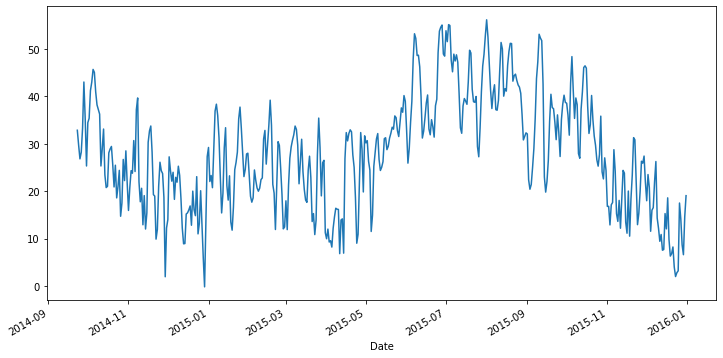

In [34]:
otg.plot(figsize=(12,6))

count    464.000000
mean      28.022615
std       11.898322
min       -0.165958
25%       19.074167
50%       27.355000
75%       36.115208
max       56.153750
Name: Temperature, dtype: float64

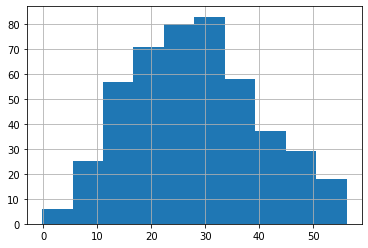

In [35]:
itog = otg.describe()
otg.hist()
itog

In [36]:
"""
Простое экспоненциальное сглаживание
"""
def exponential_smoothing(series, alpha):
    result = [series[0]] # first value is same as series
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

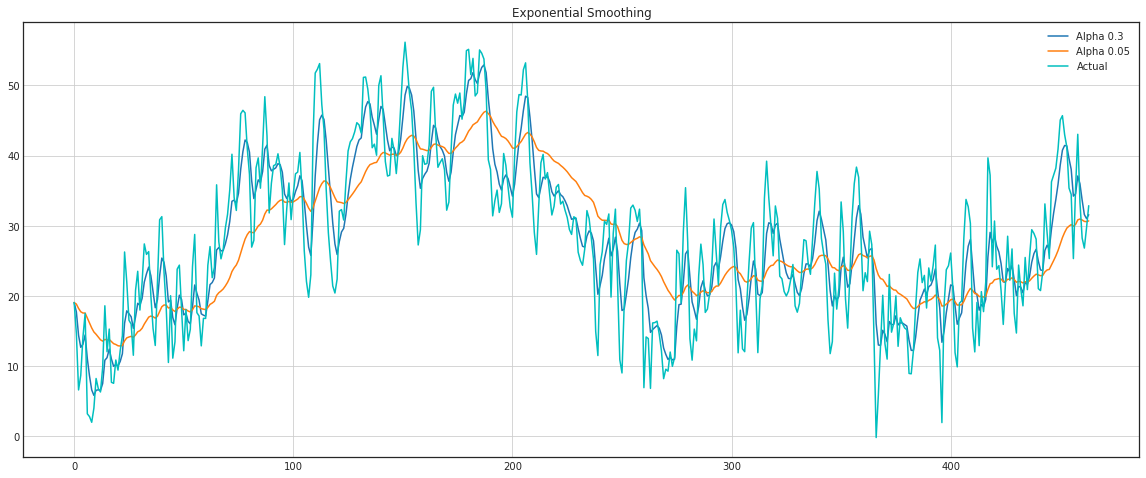

In [37]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.3, 0.05]:
        plt.plot(exponential_smoothing(dataset.Temperature, alpha), label="Alpha {}".format(alpha))
    plt.plot(dataset.Temperature.values, "c", label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Exponential Smoothing")
    plt.grid(True) 

In [60]:
row =  [u'JB', u'p-value', u'skew', u'kurtosis']# тест Харки — Бера
jb_test = sm.stats.stattools.jarque_bera(otg)
a = np.vstack([jb_test])
itog = SimpleTable(a, row)
itog

JB,p-value,skew,kurtosis
8.769887346916667,0.012463590145491192,0.18655695596303856,2.439285392112198


In [65]:
test = sm.tsa.adfuller(otg)
print ('adf: ', test[0]) 
print ('p-value: ', test[1])
print ('Critical values: ', test[4])
if test[0]> test[4]['5%']: 
    print ('есть единичные корни, ряд не стационарен')
else:
    print ('единичных корней нет, ряд стационарен')

adf:  -2.734277617601364
p-value:  0.06829223322393575
Critical values:  {'1%': -3.444932949082776, '5%': -2.867969899953726, '10%': -2.57019489663276}
есть единичные корни, ряд не стационарен


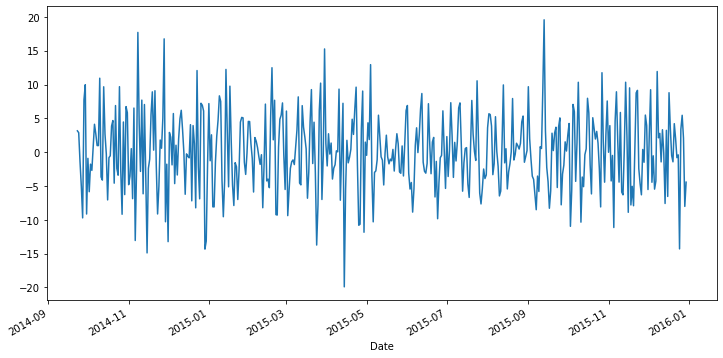

In [68]:
otg1diff = otg.diff(periods=1).dropna()
otg1diff.plot(figsize=(12,6))

In [38]:
def weighted_average(series, weights):
    result = 0.0
    weights.reverse()
    for n in range(len(weights)):
        result += series[-n-1] * weights[n]
    return result

weighted_average(dataset.Temperature, [0.6, 0.2, 0.1, 0.07, 0.03])

31.3862158328

In [39]:
"""
Двойное экспоненциальное сглаживание
"""
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    for n in range(1, len(series)+1):
        if n == 1:
            level, trend = series[0], series[1] - series[0]
        if n >= len(series): # прогнозируем
            value = result[-1]
        else:
            value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return result

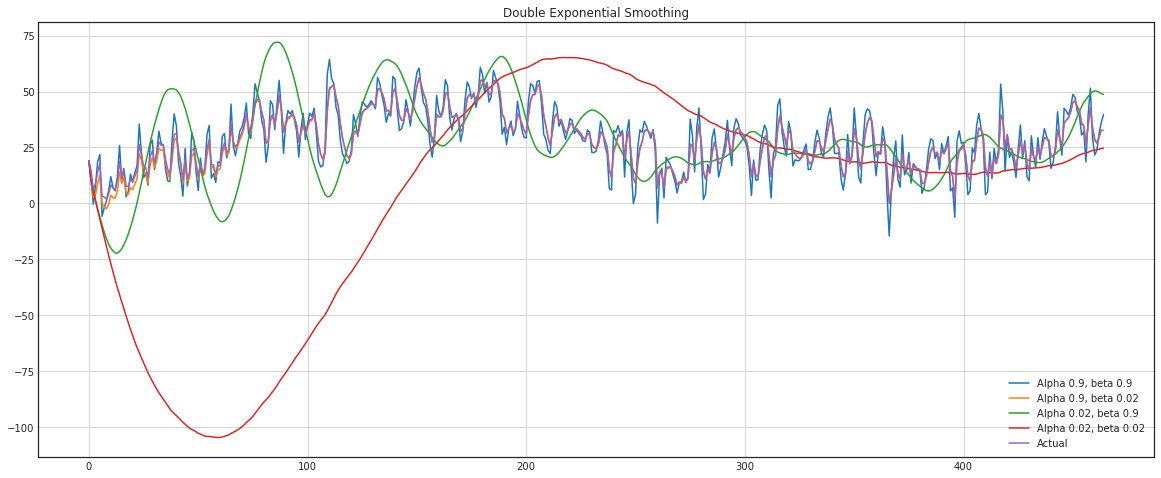

In [40]:
with plt.style.context('seaborn-white'):    
    plt.figure(figsize=(20, 8))
    for alpha in [0.9, 0.02]:
        for beta in [0.9, 0.02]:
            plt.plot(double_exponential_smoothing(dataset.Temperature, alpha, beta), label="Alpha {}, beta {}".format(alpha, beta))
    plt.plot(dataset.Temperature.values, label = "Actual")
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("Double Exponential Smoothing")
    plt.grid(True)

In [41]:

class HoltWinters:

    """
    Модель Хольта-Винтерса с методом Брутлага для детектирования аномалий
    https://fedcsis.org/proceedings/2012/pliks/118.pdf

    # series - исходный временной ряд
    # slen - длина сезона
    # alpha, beta, gamma - коэффициенты модели Хольта-Винтерса
    # n_preds - горизонт предсказаний
    # scaling_factor - задаёт ширину доверительного интервала по Брутлагу (обычно принимает значения от 2 до 3)

    """

    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor

    def initial_trend(self):
        sum = 0.0
        for i in range(self.slen):
            sum += float(self.series[i+self.slen] - self.series[i]) / self.slen
        return sum / self.slen  

    def initial_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        # вычисляем сезонные средние
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j:self.slen*j+self.slen])/float(self.slen))
        # вычисляем начальные значения
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen*j+i]-season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals   

    def triple_exponential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []

        seasonals = self.initial_seasonal_components()

        for i in range(len(self.series)+self.n_preds):
            if i == 0: # инициализируем значения компонент
                smooth = self.series[0]
                trend = self.initial_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i%self.slen])

                self.PredictedDeviation.append(0)

                self.UpperBond.append(self.result[0] + 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                self.LowerBond.append(self.result[0] - 
                                      self.scaling_factor * 
                                      self.PredictedDeviation[0])

                continue
            if i >= len(self.series): # прогнозируем
                m = i - len(self.series) + 1
                self.result.append((smooth + m*trend) + seasonals[i%self.slen])

                # во время прогноза с каждым шагом увеличиваем неопределенность
                self.PredictedDeviation.append(self.PredictedDeviation[-1]*1.01) 

            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha*(val-seasonals[i%self.slen]) + (1-self.alpha)*(smooth+trend)
                trend = self.beta * (smooth-last_smooth) + (1-self.beta)*trend
                seasonals[i%self.slen] = self.gamma*(val-smooth) + (1-self.gamma)*seasonals[i%self.slen]
                self.result.append(smooth+trend+seasonals[i%self.slen])

                # Отклонение рассчитывается в соответствии с алгоритмом Брутлага
                self.PredictedDeviation.append(self.gamma * np.abs(self.series[i] - self.result[i]) 
                                               + (1-self.gamma)*self.PredictedDeviation[-1])

            self.UpperBond.append(self.result[-1] + 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.LowerBond.append(self.result[-1] - 
                                  self.scaling_factor * 
                                  self.PredictedDeviation[-1])

            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [42]:
from sklearn.model_selection import TimeSeriesSplit

def timeseriesCVscore(x):
    # вектор ошибок
    errors = []

    values = data.values
    alpha, beta, gamma = x

    # задаём число фолдов для кросс-валидации
    tscv = TimeSeriesSplit(n_splits=3) 

    # идем по фолдам, на каждом обучаем модель, строим прогноз на отложенной выборке и считаем ошибку
    for train, test in tscv.split(values):

        model = HoltWinters(series=values[train], slen = 24*7, alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_exponential_smoothing()

        predictions = model.result[-len(test):]
        actual = values[test]
        error = mean_squared_error(predictions, actual)
        errors.append(error)

    # Возвращаем средний квадрат ошибки по вектору ошибок 
    return np.mean(np.array(errors))

Критерий Дики-Фуллера: p=0.068292


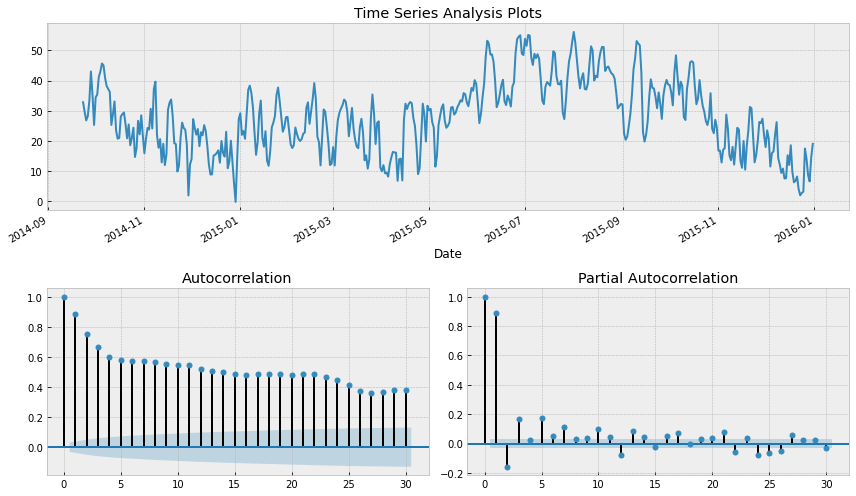

In [47]:
"""
модели SARIMA
"""
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(dataset.Temperature, lags=30)

In [48]:
otg.mean() #среднее число

28.022614895894396

In [49]:
otg.max() #максимальное число

56.15375

In [50]:
otg.min() #минимальное число

-0.165958333

In [51]:
otg.describe()

count    464.000000
mean      28.022615
std       11.898322
min       -0.165958
25%       19.074167
50%       27.355000
75%       36.115208
max       56.153750
Name: Temperature, dtype: float64

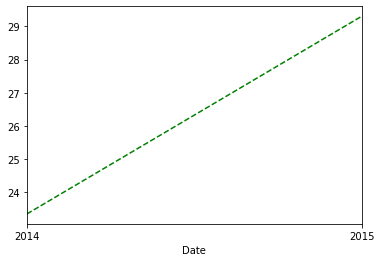

In [52]:
otg_mm = otg.resample("A").mean()
otg_mm.plot(style = 'g--')#Повторная выборка со средним

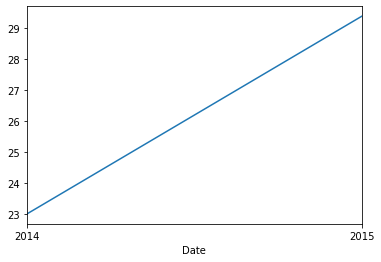

In [53]:
otg_mm = otg.resample("A").median()
otg_mm.plot()#Повторная выборка с медианой

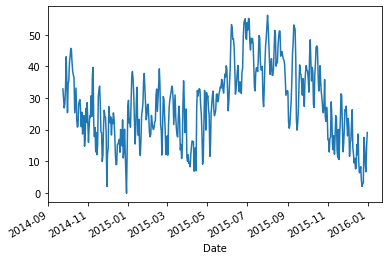

In [54]:
otg.plot()

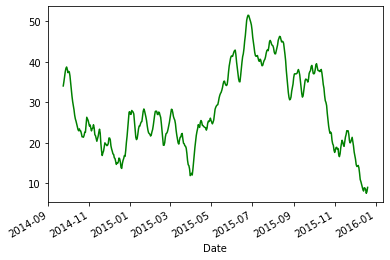

In [55]:
otg.rolling(window = 12, center = False).mean().plot(style = '-g')#Скользящее среднее

In [ ]:
data["arima_model"] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+100), lmbda)
forecast = data.arima_model.append(forecast).values[-500:]
actual = data.Users.values[-400:]
plt.figure(figsize=(15, 7))
plt.plot(forecast, color='r', label="model")
plt.title("SARIMA model\n Mean absolute error {} users".format(round(mean_absolute_error(data.dropna().Users, data.dropna().arima_model))))
plt.plot(actual, label="actual")
plt.legend()
plt.axvspan(len(actual), len(forecast), alpha=0.5, color='lightgrey')
plt.grid(True)